In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 27.9 MB/s eta 0:00:00


In [2]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [30]:
def vec_check(vec,electron_num):
    """
    To check solution conserve the charge
    """
    for i,e in enumerate(vec):
        if np.abs(e) > 1e-8:
            e_occ=bin(i)[2:]
            lst=' '.join(e_occ).split(' ')
            cv=tuple(map(int, lst))
            e_num=sum(cv)
            if e_num!=electron_num:
                return False
    return True

def exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge):
    Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]
    H_matrix=qml.matrix(Ha)
    sz=qml.qchem.spinz(len(Ha.wires))
    SZ=qml.matrix(sz)
    vals, vecs = np.linalg.eigh(H_matrix+0.0001*SZ)

    inds=np.argsort(vals)
    eng=vals[inds]
    vec=vecs[:,inds]

    print('The ground state energy with sz=0:',eng[0])
    E_collect=[eng[0]]

    elec_num=num_electrons

    for i in range(1,len(eng)): # Finding first excited state with -1 Sz
        Sz=vec[:,i].dot(SZ.dot(np.transpose(np.conjugate(vec[:,i]))))
        if  np.abs(Sz)<1e-5 and vec_check(vec[:,i],elec_num):
            print('The excited energy:',(eng[i]-0.0001*Sz).real, ' with Sz=', np.round(Sz.real,3))
            E_collect.append(eng[i])


    return E_collect

In [42]:
r_lst=[0.5,0.8,1.0,1.3,1.5,1.6,2.0,2.3,2.5,2.8,3.0,3.3,3.5]
E_dict={}
for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "H","H"]
    geometry=np.array([-L/2/np.sqrt(3), L/2, 0.0, L/np.sqrt(3), 0.0, 0.0,-L/2/np.sqrt(3), -L/2, 0.0])

    charge=1
    num_electrons=2
    E_c=exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge)
    for i,e in enumerate(E_c):
        if i not in E_dict:
            E_dict[i]=[e]
        else:
            E_dict[i].append(e)

The ground state energy with sz=0: -0.7410926671139108
The excited energy: 0.4113813451223493  with Sz= -0.0
The excited energy: 0.41138134512305674  with Sz= -0.0
The excited energy: 0.6913800845355106  with Sz= -0.0
The excited energy: 0.6913800845355939  with Sz= -0.0
The excited energy: 1.750432036024801  with Sz= 0.0
The excited energy: 1.8797987481492873  with Sz= -0.0
The excited energy: 1.8797987481493093  with Sz= -0.0
The excited energy: 1.9945766686605009  with Sz= -0.0
The ground state energy with sz=0: -1.2357257909838706
The excited energy: -0.5299572542154178  with Sz= -0.0
The excited energy: -0.5299572542149681  with Sz= -0.0
The excited energy: -0.28192118956557105  with Sz= -0.0
The excited energy: -0.281921189565533  with Sz= -0.0
The excited energy: 0.3274316542945305  with Sz= -0.0
The excited energy: 0.5063134913411788  with Sz= -0.0
The excited energy: 0.5063134913412236  with Sz= -0.0
The excited energy: 0.6276634402734302  with Sz= -0.0
The ground state energy

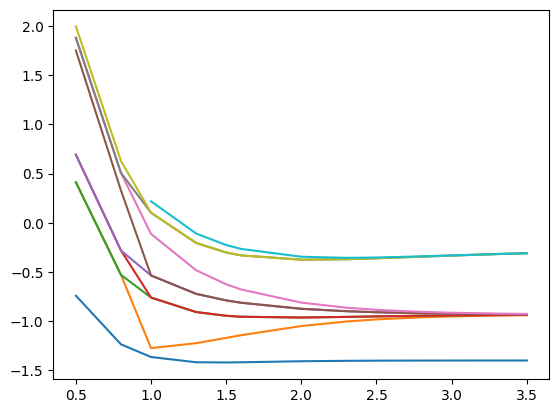

In [45]:
for i in E_dict.keys():
    if i==9:
        plt.plot(r_lst[2:],E_dict[i])
    else:
      plt.plot(r_lst,E_dict[i])

In [26]:
def depth(qnode):
    def _fn(*args, **kwargs):
        qnode.construct(args, kwargs)
        return qnode.qtape.get_depth()
    return _fn

In [25]:
def bit_to_vec(bitstring_dict,num_qubits):
    vec=np.zeros(2**num_qubits)
    amp=0
    for i in range(2**num_qubits):
        bitstr=bin(i)[2:]
        if len(bitstr) < num_qubits:
            bitstr=(num_qubits-len(bitstr))*'0'+bitstr

        if bitstr in bitstring_dict:
            vec[i]=bitstring_dict[bitstr]
            amp+=np.abs(bitstring_dict[bitstr])**2
    vec=vec/np.sqrt(amp)
    return vec

In [9]:
class FS_VQD_ch():
    def __init__(self,state_lst,num_electrons,symbol,geometry,charge) -> None:
        self.num_electrons=num_electrons
        self.symbol=symbol
        self.geometry=geometry
        self.charge=charge

        self.hamiltonian=self.Ch_hamiltonian(symbol,geometry,num_electrons,charge)
        self.num_qubits = len(self.hamiltonian.wires)
        self.sz=qml.qchem.spinz(self.num_qubits)
        self.singles, self.doubles = qml.qchem.excitations(self.num_electrons, self.num_qubits)
        self.state_lst=[]
        for stat in state_lst:
            self.state_lst.append(bit_to_vec(stat,self.num_qubits))
        H_matrix=qml.matrix(self.hamiltonian)
        H_sq=H_matrix.dot(H_matrix)
        self.H_sq_ob=qml.Hermitian(H_sq, wires=range(self.num_qubits))

        self.weight_dict={}
        self.th_state=0
        self.Eng_lst=[]

        self.dev = qml.device("default.qubit", wires=self.num_qubits)
        self.cost_h_fn = qml.QNode(self.circuit, self.dev)
        self.Sz_fn = qml.QNode(self.circuit_sz, self.dev)
        self.cost_fid_fn = qml.QNode(self.circuit_fid, self.dev)
        self.cost_hsq_fn = qml.QNode(self.circuit_h_sq, self.dev)
        self.num_ly_lst=[]

    def Ch_hamiltonian(self,symbol,geometry,num_electrons,charge):
        return qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]

    def hf(self,electrons, num_qubits):
        return qml.qchem.hf_state(electrons=electrons, orbitals=num_qubits)

    def circuit(self,state,weights):
        #qml.BasisState(state, wires=range(self.num_qubits))
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.hamiltonian)

    def circuit_h_sq(self,state,weights):
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.H_sq_ob)

    def circuit_sz(self,state,weights):
        #qml.BasisState(state, wires=range(self.num_qubits))
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.sz)

    def circuit_fid(self,state,params,weights,ind):
        #qml.BasisState(state, wires=range(num_qubits))
        qml.StatePrep(state, wires=range(self.num_qubits))
        Re_w=weights.copy()[::-1]
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(params[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(params[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])

        Re_single=self.singles.copy()[::-1]
        Re_double=self.doubles.copy()[::-1]
        for j in range(self.num_ly_lst[ind]):
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(-Re_w[i+j*(d_l+s_l)], wires=Re_double[i])
            for i in range(len(self.singles)):
                qml.SingleExcitation(-Re_w[i+d_l+j*(d_l+s_l)], wires=Re_single[i])

        return qml.state() #qml.probs(wires=range(num_qubits))

    def cost_fn(self,params):
        cost=np.sqrt(self.cost_hsq_fn(self.stat,params)-2*self.om*self.cost_h_fn(self.stat,params)+self.om**2)
        for ind in range(self.th_state):
            coj_stat=np.conjugate(np.transpose(self.state_lst[ind]))
            final_stat=self.cost_fid_fn(self.stat,params,self.weight_dict[ind],ind)
            fid=np.abs(np.dot(coj_stat,final_stat))**2
            cost+=self.beta*fid#[stat_ind]
        return cost

    def run(self,om=0.0,beta=3.0,epochs=400,stepsize=0.5,num_layer=2,cov=1e-6,print_train=True):
        self.om=om
        if self.th_state==len(self.state_lst):
            print('Run of states')
            return None
        self.beta=beta
        self.stat=self.state_lst[self.th_state]
        self.num_layer=num_layer
        opt = qml.AdamOptimizer(stepsize=stepsize)
        self.weights =np.zeros(num_layer*len(self.singles+self.doubles), requires_grad=True)

        i=0
        iter=[]
        cost_val=[]
        Lowest_cost=0

        cov=cov
        E_pev=0

        for _ in range(epochs):
            self.weights = opt.step(self.cost_fn, self.weights)
            iter.append(i)
            cost=self.cost_fn(self.weights)

            E0=self.cost_h_fn(self.stat,self.weights)

            cost_val.append(E0)

            i=i+1
            if print_train:
                print('iter:',i)
                print(' E0:',E0,' Sz:',self.Sz_fn(self.stat,self.weights))
                print(cost)
            if np.abs(E0-E_pev)<cov:
                break

            E_pev=E0
        self.Eng_lst=E0
        self.weight_dict[self.th_state]=self.weights
        self.th_state+=1
        self.num_ly_lst.append(num_layer)
        return self.cost_h_fn(self.stat,self.weights)

## To Get excited states near $0$ Ha

In [ ]:
r_lst=[0.5,0.8,1.0,1.3,1.5,1.6,2.0,2.3,2.5,2.8,3.0,3.3,3.5]
E1_lst=[]
E2_lst=[]
E3_lst=[]
for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "H","H"]
    geometry=np.array([-L/2/np.sqrt(3), L/2, 0.0, L/np.sqrt(3), 0.0, 0.0,-L/2/np.sqrt(3), -L/2, 0.0])

    charge=1
    num_electrons=2
    e_stat_1={'001100': 1}
    e_stat_2={'010010': 1}
    e_stat_3={'100001': 1}
    stat_lst=[e_stat_1,e_stat_2,e_stat_3]
    FS_VQD=FS_VQD_ch(stat_lst,num_electrons,symbol,geometry,charge)
    E1=FS_VQD.run(om=-0.0,beta=5.0,epochs=400,stepsize=0.2,num_layer=2)
    E2=FS_VQD.run(om=-0.0,beta=5.0,epochs=400,stepsize=0.2,num_layer=2)
    E3=FS_VQD.run(om=-0.0,beta=5.0,epochs=400,stepsize=0.2,num_layer=2)
    E1_lst.append(E1)
    E2_lst.append(E2)
    E3_lst.append(E3)

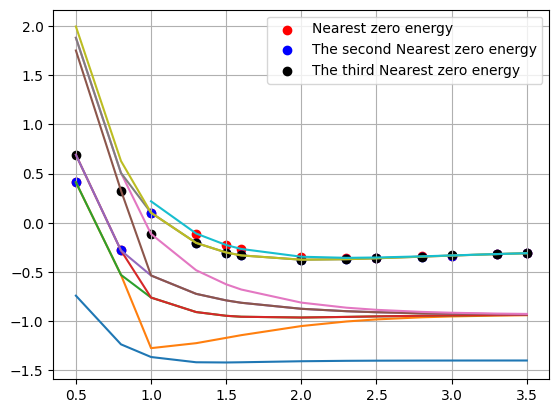

In [53]:
for i in E_dict.keys():
    if i==9:
        plt.plot(r_lst[2:],E_dict[i])
    else:
      plt.plot(r_lst,E_dict[i])
plt.scatter(r_lst,E1_lst,c='r',label='Nearest zero energy')
plt.scatter(r_lst,E2_lst,c='b',label='The second Nearest zero energy')
plt.scatter(r_lst,E3_lst,c='k',label='The third Nearest zero energy')

plt.legend()
plt.grid()

Sz=1

In [54]:
def exact_ch_energy_sz_1(num_electrons,symbol,geometry,charge):
    Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]
    H_matrix=qml.matrix(Ha)
    sz=qml.qchem.spinz(len(Ha.wires))
    SZ=qml.matrix(sz)
    vals, vecs = np.linalg.eigh(H_matrix+0.0001*SZ)

    inds=np.argsort(vals)
    eng=vals[inds]
    vec=vecs[:,inds]

    print('The ground state energy with sz=0:',eng[0])
    E_collect=[eng[0]]

    elec_num=num_electrons

    for i in range(1,len(eng)): # Finding first excited state with -1 Sz
        Sz=vec[:,i].dot(SZ.dot(np.transpose(np.conjugate(vec[:,i]))))
        if  np.abs(Sz-1)<1e-5 and vec_check(vec[:,i],elec_num):
            print('The excited energy:',(eng[i]-0.0001*Sz).real, ' with Sz=', np.round(Sz.real,3))
            E_collect.append(eng[i])


    return E_collect

In [56]:
r_lst=[0.5,0.8,1.0,1.3,1.5,1.6,2.0,2.3,2.5,2.8,3.0,3.3,3.5]
E_dict={}
for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "H","H"]
    geometry=np.array([-L/2/np.sqrt(3), L/2, 0.0, L/np.sqrt(3), 0.0, 0.0,-L/2/np.sqrt(3), -L/2, 0.0])

    charge=1
    num_electrons=2
    E_c=exact_ch_energy_sz_1(num_electrons,symbol,geometry,charge)
    for i,e in enumerate(E_c):
        if i not in E_dict:
            E_dict[i]=[e]
        else:
            E_dict[i].append(e)

The ground state energy with sz=0: -0.7410926671139108
The excited energy: 0.4113813451223488  with Sz= 1.0
The excited energy: 0.4113813451230563  with Sz= 1.0
The excited energy: 1.7504320360247996  with Sz= 1.0
The ground state energy with sz=0: -1.2357257909838706
The excited energy: -0.5299572542154185  with Sz= 1.0
The excited energy: -0.5299572542149682  with Sz= 1.0
The excited energy: 0.3274316542945309  with Sz= 1.0
The ground state energy with sz=0: -1.3644390845307146
The excited energy: -0.7602278578489391  with Sz= 1.0
The excited energy: -0.7602278578485816  with Sz= 1.0
The excited energy: -0.11396231279720231  with Sz= 1.0
The ground state energy with sz=0: -1.4177777801972233
The excited energy: -0.9075198872101988  with Sz= 1.0
The excited energy: -0.907519887209912  with Sz= 1.0
The excited energy: -0.48250314956759127  with Sz= 1.0
The ground state energy with sz=0: -1.4199425061061475
The excited energy: -0.9455354886337954  with Sz= 1.0
The excited energy: -0.945

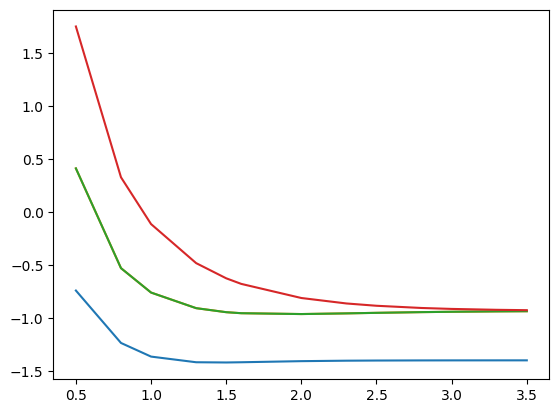

In [57]:
for i in E_dict.keys():
    plt.plot(r_lst,E_dict[i])

In [ ]:
r_lst=[0.5,0.8,1.0,1.3,1.5,1.6,2.0,2.3,2.5,2.8,3.0,3.3,3.5]
E1_lst=[]
E2_lst=[]
E3_lst=[]
for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "H","H"]
    geometry=np.array([-L/2/np.sqrt(3), L/2, 0.0, L/np.sqrt(3), 0.0, 0.0,-L/2/np.sqrt(3), -L/2, 0.0])

    charge=1
    num_electrons=2
    e_stat_1={'101000': 1}
    e_stat_2={'101000': 1}
    e_stat_3={'100010': 1}
    stat_lst=[e_stat_1,e_stat_2,e_stat_3]
    FS_VQD=FS_VQD_ch(stat_lst,num_electrons,symbol,geometry,charge)
    E1=FS_VQD.run(om=-0.0,beta=5.0,epochs=400,stepsize=0.2,num_layer=2)
    E2=FS_VQD.run(om=-0.0,beta=5.0,epochs=400,stepsize=0.2,num_layer=2)
    E3=FS_VQD.run(om=-0.0,beta=5.0,epochs=400,stepsize=0.2,num_layer=2)
    E1_lst.append(E1)
    E2_lst.append(E2)
    E3_lst.append(E3)

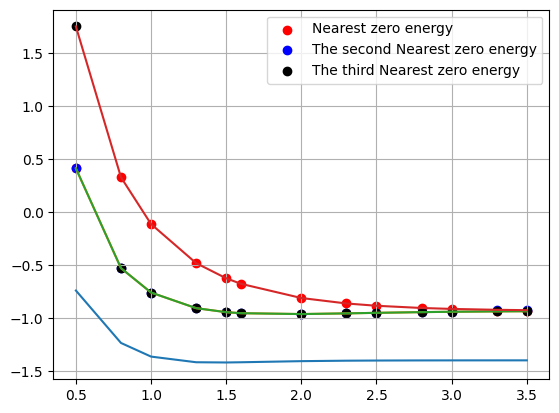

In [60]:
for i in E_dict.keys():
    plt.plot(r_lst,E_dict[i])
plt.scatter(r_lst,E1_lst,c='r',label='Nearest zero energy')
plt.scatter(r_lst,E2_lst,c='b',label='The second Nearest zero energy')
plt.scatter(r_lst,E3_lst,c='k',label='The third Nearest zero energy')

plt.legend()
plt.grid()